In [5]:
from simtk import unit, openmm
from openmmtools import cache, alchemy
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import storage

from blues import utils
import parmed
import logging
import os, sys, copy
import numpy as np
from blues.moves import RandomLigandRotationMove, ModLangevinDynamicsMove
from blues.simulation import NCMCSampler, SystemFactory
from blues.reporters import NetCDF4Reporter, NetCDF4Storage, BLUESStateDataStorage

from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
#from ncmc_switching import *
import mdtraj as md
from openmmtools import testsystems
import math
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalState
import numpy as np
from mdtraj.reporters import HDF5Reporter
from blues.reporters import *
import parmed, sys
from simtk.openmm.app.simulation import Simulation
import mdtraj as md
import matplotlib.pyplot as plt
%matplotlib inline


finfo = np.finfo(np.float32)
rtol = finfo.precision
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logging.getLogger("parmed").setLevel(logging.ERROR)
logging.getLogger("openmmtools.alchemy").setLevel(logging.ERROR)
np.random.RandomState(seed=3134)

from blues.reporters import init_logger
logger = init_logger(logger)
#logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO, stream=sys.stdout)

In [6]:
def runTestSystem(outfname):
    # Define parameters
    temperature = 200 * unit.kelvin
    collision_rate = 1 / unit.picoseconds
    timestep = 1.0 * unit.femtoseconds
    n_steps = 100
    reportInterval = 25
    nIter=100

    context_cache = cache.ContextCache(capacity=1)
    struct1 = parmed.load_file('sqB.pdb')
    struct2 = parmed.load_file('eth.prmtop', xyz='eth.inpcrd')
    struct = struct1 + struct2
    system = struct.createSystem(nonbondedMethod=NoCutoff, constraints=HBonds, removeCMMotion=True)
    system.removeForce(4)

    nonbonded = system.getForce(3)
    particles = system.getNumParticles()
    parameter_list = [nonbonded.getParticleParameters(i) for i in range(particles)]
    #for i in range(particles):
    #    print(nonbonded.getParticleParameters(i))
    #print(parameter_list)
    system.removeForce(3)

    #if you want to make the system use lambda parameters
    pairwiseForce = CustomNonbondedForce("q/(r^2) + 4*epsilon*((sigma/r)^12-(sigma/r)^6); sigma=0.5*(sigma1+sigma2)*lambda_sterics; epsilon=sqrt(epsilon1*epsilon2)*lambda_electrostatics; q = lambda_charge*(q1*q2)")
    #else just use normal parameters
    #pairwiseForce = CustomNonbondedForce("q/(r^2) + 4*epsilon*((sigma/r)^12-(sigma/r)^6); sigma=0.5*(sigma1+sigma2); epsilon=sqrt(epsilon1*epsilon2); q = q1*q2"
    pairwiseForce.addPerParticleParameter("sigma")
    pairwiseForce.addPerParticleParameter("epsilon")
    pairwiseForce.addPerParticleParameter("q")
    pairwiseForce.addPerParticleParameter("lambda_on")
    #pairwiseForce.addPerParticleParameter("lambda_on")
    pairwiseForce.addGlobalParameter("lambda_sterics", 1)
    pairwiseForce.addGlobalParameter("lambda_electrostatics", 1)
    pairwiseForce.addGlobalParameter("lambda_charge", 1)

    for i, parameter in enumerate(parameter_list):
        new_param = [parameter[1]*1.2] + [parameter[2]]+[parameter[0]]
        pairwiseForce.addParticle()
        pairwiseForce.setParticleParameters(i,new_param+[0])
    pairwiseForce.setParticleParameters(0, [0.324999852378,0.71128, -0.2, 10])
    pairwiseForce.setParticleParameters(1, [0.324999852378,0.71128, -0.5, 10])
    numParticles = system.getNumParticles()
    rangeparticles = range(numParticles)
    pairwiseForce.addInteractionGroup([0,1], rangeparticles[2:])
    num_params = pairwiseForce.getNumPerParticleParameters()
    system.addForce(pairwiseForce)
#     for i, parameter in enumerate(parameter_list):
#         print('param', pairwiseForce.getParticleParameters(i))
#     for i in range(pairwiseForce.getNumPerParticleParameters()):
#         print(i, pairwiseForce.getPerParticleParameterName(i))


    centoridForce = CustomCentroidBondForce(2, ('0.5*k*distance(g1,g2)^2'))
    centoridForce.addPerBondParameter('k')
    centoridForce.addGroup([0,1], [1,1])
    centoridForce.addGroup([2,3])
    bondGroups = [0,1]
    bondParameters=[100000]
    centoridForce.addBond(bondGroups, bondParameters)
    system.addForce(centoridForce)
    system.setParticleMass(0, 0)
    system.setParticleMass(1, 0)

    # Create our State objects
    sampler_state = SamplerState(positions=struct.positions)
    thermodynamic_state = ThermodynamicState(system=system, temperature=temperature)

    # Create our AlchemicalState
    alchemical_atoms = utils.atomIndexfromTop('TMP',struct.topology)
    toluene_alchemical_system = SystemFactory.generateAlchSystem(system, alchemical_atoms)
    alchemical_state = alchemy.AlchemicalState.from_system(toluene_alchemical_system)
    alch_thermodynamic_state = ThermodynamicState(system=toluene_alchemical_system, temperature=temperature)
    alch_thermodynamic_state = CompoundThermodynamicState(alch_thermodynamic_state, composable_states=[alchemical_state])
    alch_thermodynamic_state.topology = struct.topology

    # Iniitialize our Move set
    ncmc_move = RandomLigandRotationMove(atom_subset=alchemical_atoms, context_cache=context_cache, n_steps=n_steps)
    langevin_move = ModLangevinDynamicsMove(timestep, collision_rate, n_steps,
                                         reassign_velocities=True,
                                        context_cache=context_cache)

    # Create a reporter
    with open(outfname+'.pdb', 'w') as pdb:
        pdbfile.PDBFile.writeFile(struct.topology, struct.positions, pdb)
    filename = outfname+'.nc'
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print("Sorry, I can not remove %s file." % filename)
    nc_reporter = NetCDF4Storage(filename, reportInterval)

    #state_reporter = BLUESStateDataStorage(file=logger, step=True, reportInterval=reportInterval, progress=True, remainingTime=True, speed=True, totalSteps=n_steps, currentIter=False)

    sampler = NCMCSampler(alchemical_atoms, thermodynamic_state, alch_thermodynamic_state,
                     sampler_state, move=[langevin_move, ncmc_move], platform=None,
                     reporter=[nc_reporter], topology=struct.topology)
    
    


    sampler.minimize()
    sampler.run(nIter)
    
    acceptance = sampler.n_accepted / sampler.n_proposed
    
    
    traj = md.load(outfname+'.nc', top=outfname+'.pdb')
    print(traj)
    dist = md.compute_distances(traj, [[0,2]])
    count_list = [0 if i <=0.49 else 1 for i in dist]
    counts = (count_list.count(0), count_list.count(1))
    plt.figure(1)
    plt.subplot(211)
    plt.plot(dist)
    plt.subplot(212)
    plt.bar([0,1], counts)
    total = counts[0] + counts[1]
    counts0 = counts[0]/total
    counts1 = counts[1]/total
    plt.legend(['{:.2f} {:.2f}'.format(counts0,counts1)])
    plt.show()
    
    return (acceptance, counts0, counts1)

-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -1.4279388902718453 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.4279388902718453 < -0.6796464726471917
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc -1.409558992187427 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -1.409558992187427 > randnum -1.8989788996441104
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc 0.9002334835316704 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.9002334835316704 > randnum -0.97

Proposing positions...
work_ncmc -1.3825377002979478 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.3825377002979478 < -0.2909897797547338
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc -0.9301366259874538 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.9301366259874538 < -0.27674468308892836
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc -0.9500443349989635 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.9500443349989635 < -0.7471102039101114
MD Simulation
................................................................................
............................................................

................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc -0.43820387406541883 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.43820387406541883 > randnum -1.3787524833990823
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc -0.024528132710500746 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.024528132710500746 > randnum -0.2826660255615184
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 49
NCMC Simulation
Proposing positions...
work_ncmc -0.17193378554741243 + corr 0.0
N

................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc -0.43064367603749726 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.43064367603749726 < -0.05435911448040346
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc -0.07257259616899432 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.07257259616899432 > randnum -0.5332296812805093
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 72
NCMC Simulation
Proposing positions...
work_ncmc 0.2838447889516602 + corr 0.0
NCMC MOVE AC

................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc -0.19938477426013596 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.19938477426013596 > randnum -2.715117120074561
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc -0.1344024850055768 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.1344024850055768 > randnum -1.0456812188917783
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 95
NCMC Simulation
Proposing positions...
work_ncmc -0.18303335487283579 + corr 0.0
NCMC M

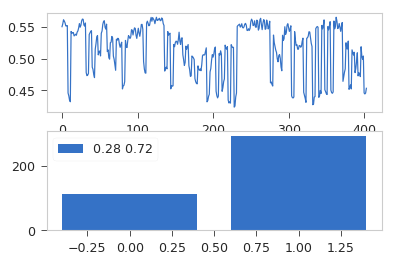

-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -1.5085925682054468 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.5085925682054468 < -0.8300653059620994
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc -0.5833024693171364 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.5833024693171364 > randnum -2.4419894570036695
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc 0.294476953657872 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.294476953657872 > randnum -0.31

Proposing positions...
work_ncmc 0.0347416405185231 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.0347416405185231 > randnum -0.4068140062636508
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc 0.06334622971166873 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.06334622971166873 > randnum -0.9849608885714222
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc -0.11081102541694997 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.11081102541694997 > randnum -0.6795904730402271
MD Simulation
................................................................................
.....................................

................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc 1.0378986248301239 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 1.0378986248301239 > randnum -0.40613202404806603
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc -1.5266748184403303 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.5266748184403303 < -0.8128467135129327
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 49
NCMC Simulation
Proposing positions...
work_ncmc -1.9290247436940227 + corr 0.0
NCMC MOVE ACCEPTE

................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc 0.5591673292634635 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.5591673292634635 > randnum -0.8713721837776877
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc 0.09413529030920299 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.09413529030920299 > randnum -1.758362680794144
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 72
NCMC Simulation
Proposing positions...
work_ncmc 0.31703940620598314 + corr 0.0
NCMC MOVE A

................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc -0.6856547615072082 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.6856547615072082 > randnum -2.6921144088226834
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc 0.13054238237887983 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.13054238237887983 > randnum -0.9151579480389055
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 95
NCMC Simulation
Proposing positions...
work_ncmc 0.06666365550287011 + corr 0.0
NCMC MOV

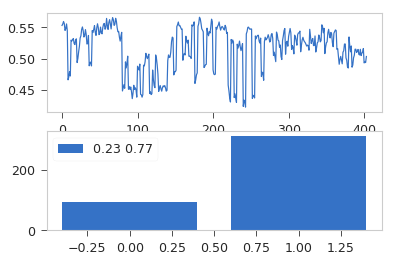

-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -1.7388210291857917 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.7388210291857917 < -0.04394201875845156
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc -1.122383013382159 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.122383013382159 < -0.5394462465442046
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc 0.08972906983140887 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.08972906983140887 > randnum -1.0389682

................................................................................
................................................................................
MCMC sampler iteration 23
NCMC Simulation
Proposing positions...
work_ncmc -0.037499041020571014 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.037499041020571014 > randnum -0.9781787477245425
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc -0.377223916082421 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.377223916082421 > randnum -1.3955927743697523
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc -0.13607023056713158 + corr 0.0
NCMC 

................................................................................
................................................................................
MCMC sampler iteration 46
NCMC Simulation
Proposing positions...
work_ncmc -1.8781238071592863 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.8781238071592863 < -1.105815235775979
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc -1.7322993009912901 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.7322993009912901 < -0.36596204151659595
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc -1.9260703450487855 + corr 0.0
NCMC MOVE REJECTED: work

................................................................................
................................................................................
MCMC sampler iteration 69
NCMC Simulation
Proposing positions...
work_ncmc -0.919663608252814 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.919663608252814 > randnum -1.3425148843676362
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc 0.8200843445106473 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.8200843445106473 > randnum -0.776004777057384
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc -0.5722120760333171 + corr 0.0
NCMC MOVE REJ

................................................................................
................................................................................
MCMC sampler iteration 92
NCMC Simulation
Proposing positions...
work_ncmc 0.21259239576846337 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.21259239576846337 > randnum -0.35285252816785995
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc -0.6156650776741328 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.6156650776741328 < -0.20532549258686567
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc -1.4162041668166343 + corr 0.0
NCMC MOVE REJE

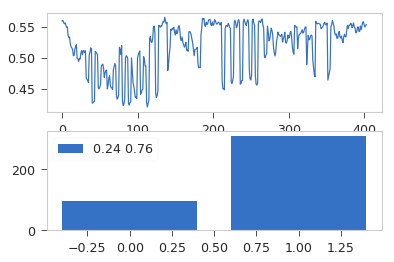

Sorry, I can not remove test_3.nc file.
-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -1.4546245397645223 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.4546245397645223 < -0.2890116254612771
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc -1.9317893129785737 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -1.9317893129785737 > randnum -2.4155489664862326
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc 1.849928698822726 + corr 0.0
NCMC MOVE ACCEPTED: wor

................................................................................
................................................................................
MCMC sampler iteration 23
NCMC Simulation
Proposing positions...
work_ncmc 0.24822339544433897 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.24822339544433897 > randnum -2.638177732947621
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc -0.4508734067590527 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.4508734067590527 > randnum -1.22929052728803
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc -0.06316242212828554 + corr 0.0
NCMC MOVE 

................................................................................
................................................................................
MCMC sampler iteration 46
NCMC Simulation
Proposing positions...
work_ncmc 0.15956476821631455 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.15956476821631455 > randnum -2.546784604140322
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc -0.21829286823939326 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.21829286823939326 > randnum -0.8148674323743129
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc 0.2433219554712207 + corr 0.0
NCMC MOV

................................................................................
................................................................................
MCMC sampler iteration 69
NCMC Simulation
Proposing positions...
work_ncmc 0.3046345449623691 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.3046345449623691 > randnum -4.969943630285956
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc -1.2730485983745963 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -1.2730485983745963 > randnum -1.5137875191606112
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc 1.0017404328889596 + corr 0.0
NCMC MOVE AC

................................................................................
................................................................................
MCMC sampler iteration 92
NCMC Simulation
Proposing positions...
work_ncmc 0.33053736340569195 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.33053736340569195 > randnum -2.8120983369249357
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc -1.2783109148589278 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.2783109148589278 < -1.2091296923275263
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc -1.3843265982838076 + corr 0.0
NCMC MOVE ACCEPT

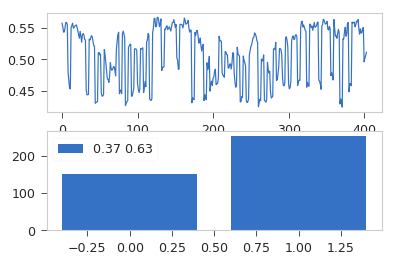

Sorry, I can not remove test_4.nc file.
-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -1.4903381238148352 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.4903381238148352 < -1.152677415203256
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc -1.9809402063286181 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.9809402063286181 < -0.4525121272908271
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc -1.3948913764344888 + corr 0.0
NCMC MOVE REJECTED: work_ncmc 

Proposing positions...
work_ncmc -1.6841073039888799 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.6841073039888799 < -0.3838378536014354
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc -0.197336509723309 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.197336509723309 > randnum -5.1752067172136
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc -0.9792575538266346 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.9792575538266346 < -0.43536035709325127
MD Simulation
................................................................................
.........................................................

................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc -1.7351937686148002 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.7351937686148002 < -0.11607766493993958
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc -1.7211068242446248 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -1.7211068242446248 > randnum -2.2360254506095742
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 49
NCMC Simulation
Proposing positions...
work_ncmc 0.3423483627067373 + corr 0.0
NCMC MOVE ACCEPT

................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc -0.5592533546535025 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.5592533546535025 > randnum -0.7528961948979735
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc -0.5709387568850909 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.5709387568850909 < -0.2607168998347816
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 72
NCMC Simulation
Proposing positions...
work_ncmc 0.10423639160757447 + corr 0.0
NCMC MOVE ACCEPT

................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc 0.6884943162567433 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.6884943162567433 > randnum -1.12883971717374
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc -0.7870815638761111 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.7870815638761111 < -0.2546915147060571
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 95
NCMC Simulation
Proposing positions...
work_ncmc -1.570634222877175 + corr 0.0
NCMC MOVE REJECTED: w

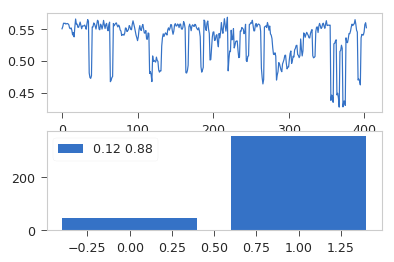

Sorry, I can not remove test_5.nc file.
-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -1.3787743762350446 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.3787743762350446 < -0.38402434616651265
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc 0.4374216165186648 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.4374216165186648 > randnum -2.8266650979827728
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc -0.4721750138404932 + corr 0.0
NCMC MOVE REJECTED: wo

................................................................................
................................................................................
MCMC sampler iteration 23
NCMC Simulation
Proposing positions...
work_ncmc -0.5306952191709778 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.5306952191709778 > randnum -0.6797854812130719
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc 0.4423987588350173 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.4423987588350173 > randnum -0.19813525006012614
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc -0.8398779265047053 + corr 0.0
NCMC MOVE

................................................................................
................................................................................
MCMC sampler iteration 46
NCMC Simulation
Proposing positions...
work_ncmc -0.4987485435748196 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.4987485435748196 < -0.4659269134190874
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc -1.4016802134650612 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.4016802134650612 < -0.39133059647032997
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc -1.3291702724551453 + corr 0.0
NCMC MOVE REJECTED: wor

................................................................................
................................................................................
MCMC sampler iteration 69
NCMC Simulation
Proposing positions...
work_ncmc -1.3839452190546349 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.3839452190546349 < -1.1297692295223747
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc -1.3115244576990592 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.3115244576990592 < -0.20170486647901445
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc -1.5467737905690264 + corr 0.0
NCMC MOVE REJECTED: wor

................................................................................
................................................................................
MCMC sampler iteration 92
NCMC Simulation
Proposing positions...
work_ncmc -0.9271736248032129 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.9271736248032129 > randnum -1.458201401075974
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc 1.0242575787316504 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 1.0242575787316504 > randnum -2.5458736825230743
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc -1.228067785806689 + corr 0.0
NCMC MOVE RE

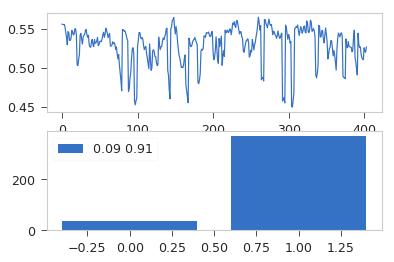

Sorry, I can not remove test_6.nc file.
-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -1.5208559176824468 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.5208559176824468 < -1.2194010085035636
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc -1.3136596078798255 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -1.3136596078798255 > randnum -2.9457604091407186
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc 1.8365692425009799 + corr 0.0
NCMC MOVE ACCEPTED: wo

................................................................................
................................................................................
MCMC sampler iteration 23
NCMC Simulation
Proposing positions...
work_ncmc 1.6396830756945246 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 1.6396830756945246 > randnum -0.1997506927243595
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc -1.5453360195501757 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -1.5453360195501757 > randnum -2.2122516738608886
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc 1.5374182426509924 + corr 0.0
NCMC MOVE A

................................................................................
................................................................................
MCMC sampler iteration 46
NCMC Simulation
Proposing positions...
work_ncmc -1.1869635640652365 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.1869635640652365 < -1.0322528849132495
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc -0.8129169957639035 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.8129169957639035 < -0.33197844175681296
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc -0.20161397886734483 + corr 0.0
NCMC MOVE ACCEPTED: wo

................................................................................
................................................................................
MCMC sampler iteration 69
NCMC Simulation
Proposing positions...
work_ncmc 1.6511466757954627 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 1.6511466757954627 > randnum -0.12986180486154275
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc -1.8955886818449903 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.8955886818449903 < -0.4898301564769468
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc -1.8828090366521066 + corr 0.0
NCMC MOVE REJECTE

................................................................................
................................................................................
MCMC sampler iteration 92
NCMC Simulation
Proposing positions...
work_ncmc 1.0351294675247706 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 1.0351294675247706 > randnum -0.8098401413195475
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc -0.7485345902292158 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.7485345902292158 > randnum -1.8181682232198548
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc 1.1073565283771085 + corr 0.0
NCMC MOVE A

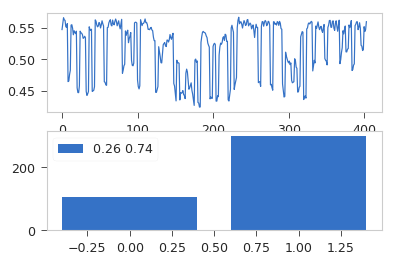

Sorry, I can not remove test_7.nc file.
-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -0.9158802115989018 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.9158802115989018 > randnum -2.1709717021916815
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc 0.887586890942047 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.887586890942047 > randnum -1.946475560953026
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc -0.8250384033473392 + corr 0.0
NCMC MOVE REJECTED

................................................................................
................................................................................
MCMC sampler iteration 23
NCMC Simulation
Proposing positions...
work_ncmc 0.26936184103600563 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.26936184103600563 > randnum -0.13217125614140254
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc -0.04257482578416817 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.04257482578416817 > randnum -2.9537264604057536
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc 0.14012317344316583 + corr 0.0
NCMC 

................................................................................
................................................................................
MCMC sampler iteration 46
NCMC Simulation
Proposing positions...
work_ncmc -1.5712761156625157 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.5712761156625157 < -0.19559465890495764
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc -1.6416382894344594 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -1.6416382894344594 > randnum -3.152634608292811
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc 1.464383546761839 + corr 0.0
NCMC MOVE ACCEPTED

................................................................................
................................................................................
MCMC sampler iteration 69
NCMC Simulation
Proposing positions...
work_ncmc -0.1075948228346944 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.1075948228346944 < -0.056911501167288776
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc -0.3254624388959952 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.3254624388959952 > randnum -0.6998945956008762
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc -0.009966041436010351 + corr 0.0
NCMC MOVE AC

................................................................................
................................................................................
MCMC sampler iteration 92
NCMC Simulation
Proposing positions...
work_ncmc 0.7624869048639802 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.7624869048639802 > randnum -1.4211884775909898
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc 0.14296459207615178 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.14296459207615178 > randnum -1.2220515978945645
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc -0.22705957236261082 + corr 0.0
NCMC MOVE

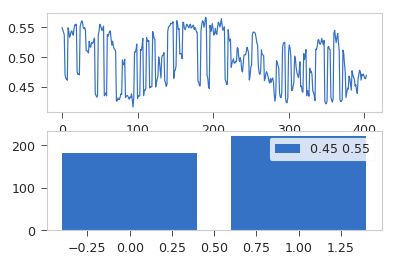

Sorry, I can not remove test_8.nc file.
-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -1.651012046060052 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -1.651012046060052 > randnum -2.9334258668167497
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc 1.909888395679862 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 1.909888395679862 > randnum -0.06832602962691028
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc -1.383181026839789 + corr 0.0
NCMC MOVE ACCEPTED:

................................................................................
................................................................................
MCMC sampler iteration 23
NCMC Simulation
Proposing positions...
work_ncmc -1.7123761074095736 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.7123761074095736 < -0.29008688314035364
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc -1.6741587543821774 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.6741587543821774 < -0.14307904818865808
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc -1.8821363181020023 + corr 0.0
NCMC MOVE REJECTED: wo

................................................................................
................................................................................
MCMC sampler iteration 46
NCMC Simulation
Proposing positions...
work_ncmc 0.5119380997512388 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.5119380997512388 > randnum -0.18006445462539697
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc 0.23943418134406122 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.23943418134406122 > randnum -2.912337214818884
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc 0.07348475205470714 + corr 0.0
NCMC MOVE 

................................................................................
................................................................................
MCMC sampler iteration 69
NCMC Simulation
Proposing positions...
work_ncmc -1.5029200539862795 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.5029200539862795 < -1.5013975761789655
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc -1.5148305559884698 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.5148305559884698 < -1.3403528311846382
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc -1.743510129821164 + corr 0.0
NCMC MOVE REJECTED: work_

................................................................................
................................................................................
MCMC sampler iteration 92
NCMC Simulation
Proposing positions...
work_ncmc -1.5177296116327819 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.5177296116327819 < -0.7172793695387654
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc -0.8222689592906859 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.8222689592906859 > randnum -0.8625550935101098
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc -0.8713468744348473 + corr 0.0
NCMC MOVE REJECT

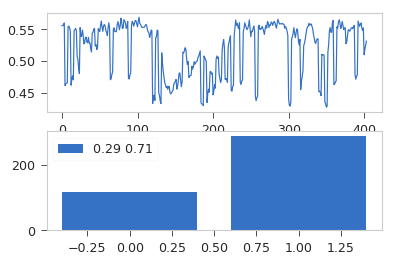

Sorry, I can not remove test_9.nc file.
-9.30112361907959 kJ/mol
MD Simulation
................................................................................
MCMC sampler iteration 0
NCMC Simulation
Proposing positions...
work_ncmc -1.3989857548733917 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.3989857548733917 < -0.35893928292097615
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 1
NCMC Simulation
Proposing positions...
work_ncmc -1.1244603831759492 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -1.1244603831759492 < -0.545340405695849
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 2
NCMC Simulation
Proposing positions...
work_ncmc -0.3311117262598519 + corr 0.0
NCMC MOVE REJECTED: work_ncmc

................................................................................
................................................................................
MCMC sampler iteration 23
NCMC Simulation
Proposing positions...
work_ncmc -0.36539743221116866 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -0.36539743221116866 > randnum -2.592358892512562
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 24
NCMC Simulation
Proposing positions...
work_ncmc 0.6115427409834672 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.6115427409834672 > randnum -0.887012946224464
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 25
NCMC Simulation
Proposing positions...
work_ncmc -0.1445464556233177 + corr 0.0
NCMC MOVE 

................................................................................
................................................................................
MCMC sampler iteration 46
NCMC Simulation
Proposing positions...
work_ncmc 0.018416745626484904 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.018416745626484904 > randnum -3.3990040383134654
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 47
NCMC Simulation
Proposing positions...
work_ncmc -0.12534816932832907 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.12534816932832907 < -0.10740247386487882
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 48
NCMC Simulation
Proposing positions...
work_ncmc -0.06869127394608775 + corr 0.0
NCMC MOVE 

................................................................................
................................................................................
MCMC sampler iteration 69
NCMC Simulation
Proposing positions...
work_ncmc -0.9029078695323308 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.9029078695323308 < -0.13440295243923298
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 70
NCMC Simulation
Proposing positions...
work_ncmc -1.1457165401763192 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc -1.1457165401763192 > randnum -1.1708698825154262
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 71
NCMC Simulation
Proposing positions...
work_ncmc 1.2084012346385886 + corr 0.0
NCMC MOVE ACCEPT

................................................................................
................................................................................
MCMC sampler iteration 92
NCMC Simulation
Proposing positions...
work_ncmc -0.2730463084913731 + corr 0.0
NCMC MOVE REJECTED: work_ncmc -0.2730463084913731 < -0.15731301672758388
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 93
NCMC Simulation
Proposing positions...
work_ncmc 0.5347412800158089 + corr 0.0
NCMC MOVE ACCEPTED: work_ncmc 0.5347412800158089 > randnum -0.09583718928027131
MD Simulation
................................................................................
................................................................................
MCMC sampler iteration 94
NCMC Simulation
Proposing positions...
work_ncmc -0.32934906601795416 + corr 0.0
NCMC MOVE ACCEP

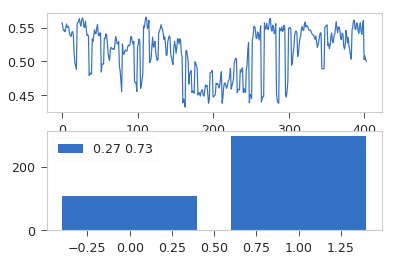

In [7]:
data = []
for i in range(10):
    outfname = 'test_%s' % i
    counts = runTestSystem(outfname)
    data.append(counts)

In [8]:
data

[(0.6, 0.27970297029702973, 0.7202970297029703),
 (0.69, 0.22772277227722773, 0.7722772277227723),
 (0.62, 0.23514851485148514, 0.7648514851485149),
 (0.7, 0.37376237623762376, 0.6262376237623762),
 (0.45, 0.1188118811881188, 0.8811881188118812),
 (0.56, 0.08663366336633663, 0.9133663366336634),
 (0.62, 0.2599009900990099, 0.7400990099009901),
 (0.71, 0.4504950495049505, 0.5495049504950495),
 (0.56, 0.2896039603960396, 0.7103960396039604),
 (0.62, 0.26732673267326734, 0.7326732673267327)]